# Text classification with movie reviews

이 가이드에서는 리뷰의 Text를 사용하여 영화의 리뷰가 Positive 인지 Negative 인지 분류할 것이다. 이는 binary, two-class classification 의 한 예제이다. 

IMDB dataset을 사용할 것이고, 50,000의 영화 리뷰로 구성되어 있으며, 25,000 개의 training에, 25,000개는 testing 에 사용될 것이다. 

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.10.0


## Download the IMDB dataset

IMDB dataset 은 Tensorflow에 패키지화되어 있으며, 리뷰는 Integer의 Sequence로 변환되어 있다. 각 Integer는 Dictionary안의 특정 단어로 표현된다. 

In [2]:
imdb = keras.datasets.imdb

# num_words = 10000 keeps the top 10,000 most frequently occursing words in the training data
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 2s 0us/step


## Explore the data

In [3]:
print('Training entries: {}, labels: {}'.format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
len(train_data[0]), len(train_data[1])

(218, 189)

### Convert the integer back to word

이 Integer 값을 Word로 변환시키기 위해서 dictionary에 query 하는 helper function을 구현해 보자.

In [6]:
word_index = imdb.get_word_index()

word_index = {k: (v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2 # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text]) 

1646592/1641221 [==============================] - 0s 0us/step


In [7]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## <U>Prepare the data</U>

Integer 배열인 이 데이터를 Neural Network에 인갛기 전에 Tensor형태로 변환해야 하고 다음과 같은 방법들이 존재한다. 

- One-hot-encode : Array를 0과 1의 Vector로 변환한다. 예를 들어 [3, 5] 값은 10,000 dimensional vector 에서 인덱스 3, 5 위치만 제외하고 전부 0이 된다. 이 과정은 Network 내 첫번째 Layer에서 수행된다. (Dense-Layer). 이 방법은 Memory intensive 하며, `num_words * num_reviews` 크기의 matrix가 필요하다. 
- Array를 Padding 하여 모두 같은 length를 갖도록 변환하여 `num_examples * max_length` 크기의 Integer tensor를 생성한다. 

이 튜토리얼에서는 두번째 방법을 사용한다.

영화 리뷰는 모두 같은 길이로 만들어주기 위해서는 `pad_sequence` 함수를 사용하면 된다. 

In [8]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                      value=word_index["<PAD>"],
                                                      padding='post',
                                                      maxlen=256)

In [9]:
len(train_data[0]), len(test_data[0])

(256, 256)

In [10]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## <U>Build the model</U>

Neural Network는 layer를 쌓아서 만들어지고, 이는 2가지 주요 architecture 결정이 필요하다.

- 얼마나 많은 Layer를 사용할 것인가?
- 각 Layer에 몇개의 hidden units 를 사용할 것인가?

이 예제에서 input data 는 word 인덱스의 배열로 구성되어 있으며, Label 은 0 또는 1로 예측하게 된다. 

In [11]:
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


1. 첫번째 layer는 Embedding layer 이다. 이 layer 는 integer-encoded vocabulary를 갖고 각 word-index 에 대한 embedding vector를 찾는다. 이 벡터들은 모델이 training될 때 학습된다. 최종 출력 dimension은 (batch, sequence, embedding) 으로 구성된다.

2. `GlobalAveragePooling1D` layer는 sequence dimension을 평균을 통해서 고정된 길이의 output vector를 리턴한다. 이 방법은 모델이 다양한 길이의 입력을 가장 간단히 다룰 수 있는 방법이다. 

3. fixed-length output vector 는 16개의 hidden unit을 갖는 fully-connected layer로 연결된다.

4. 마지막 Layer 는 single output node로 densely 하게 연결된다. `sigmoid` activation function 을 사용하여, 확률 또는 confidence level로 0~1사이 값을 출력한다.

### Hidden units

위의 모델은 input과 output 사이에 2개의 중간, Hidden Layer 를 갖고 있다. output (units, nodes, or neurons) 는 각 layer 의 representational space 의 dimension을 나타낸다. 이 수는 internal representation 을 학습할때 자유도의 크기를 나타낸다. 

만을 모델이 더 많은 hidden unit 수를 갖고, 더 많은 layers를 갖는 다면, network는 더 복잡한 표현을 학습할 수 있다. 그러나 이는 더 많은 계산적으로 더 큰 비용을 필요하며, 원하지 않은 패턴으로 학습이 될 수 있다-여기서 패턴은 training data에 대한 performance를 향상 시키지만 test data에서 대해서는 아닐 수 있다. 이를 *overfitting* 이라고 한다. 

### Loss function and optimizer 

모델은 학습을 위하여 loss function과 optimizer를 정의해야 한다. 이 예제는 binary classification이고, model의 output이 확률이기 떄문에, 여기서는 `binary_crossentropy` loss function을 사용한다.

loss function 으로 `mean_squared_error` 를 사용할 수도 있다. 그러나 일반적으로 `binary_crossentropy` 가 확률에 대해선 더 나은 성능을 보인다.- 이 함수는 확률 분포간의 거리를 측정하며, 이 예제에서는 ground-truth 분포와 prediction간의 거리를 측정한다.

In [19]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## <U>Create a validation set</U>

학습 도중에 이전에 나타나지 않은 데이터를 사용해서 모델의 정확도를 체크할 필요가 있다. 원본 training data로 부터 10,000 개의 예제를 추출하여 validation set을 생성하자. 

(우리의 목표는 training data 안에서 모델을 만들고 튜닝하는 것이므로, test set은 오직 accuracy 평가에만 사용된다.)

In [20]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## <U>Train the model</U>

In [21]:
history = model.fit(partial_x_train, 
                   partial_y_train,
                   epochs=40,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 55us/step - loss: 0.6924 - acc: 0.5217 - val_loss: 0.6905 - val_acc: 0.5230
Epoch 2/40
15000/15000 [==============================] - 1s 42us/step - loss: 0.6884 - acc: 0.5807 - val_loss: 0.6872 - val_acc: 0.6027
Epoch 3/40
15000/15000 [==============================] - 1s 41us/step - loss: 0.6849 - acc: 0.6081 - val_loss: 0.6837 - val_acc: 0.6328
Epoch 4/40
15000/15000 [==============================] - 1s 41us/step - loss: 0.6806 - acc: 0.6543 - val_loss: 0.6795 - val_acc: 0.6434
Epoch 5/40
15000/15000 [==============================] - 1s 41us/step - loss: 0.6751 - acc: 0.6709 - val_loss: 0.6738 - val_acc: 0.6605
Epoch 6/40
15000/15000 [==============================] - 1s 39us/step - loss: 0.6674 - acc: 0.7004 - val_loss: 0.6652 - val_acc: 0.6928
Epoch 7/40
15000/15000 [==============================] - 1s 41us/step - loss: 0.6576 - acc: 0.6990 - val_loss: 0.6566 - val_acc

## <U>Evaluate the model</U>

Model의 evaluate 호출 시 loss 와 accruacy를 리턴한다.

In [15]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 2s 74us/step
[0.7001511084747315, 0.5]


## <U>Create a graph of accuracy and loss over time</U>

`model.fit()` 은 Histroy object를 리턴하며, training 도중에 발생하는 모든 정보가 dictionary 형태로 담겨 있다.

In [16]:
history_dict = history.history

history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

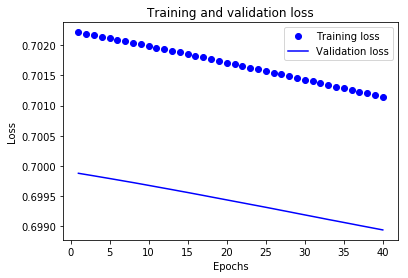

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

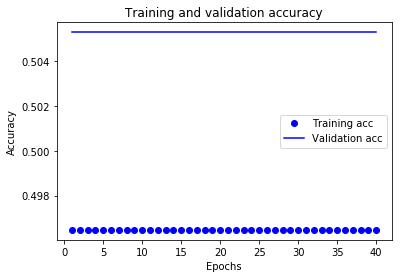

In [18]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
